# Model Metrics workflow notebook

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

# %load_ext autoreload
# %autoreload 2

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/creds/ML4CC_creds.json"

## Step 1: Get config

In [3]:
from src.models.config_setup import get_default_config

model_type = "linear"
path_to_models = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods-demo/{model_type}/model.pt"
config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)
config["data_params"]

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'bands': 'all',
                       'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'image_count': 3,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'path_to_splits': 'worldfloods_local',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True,
                                                  'use_channels': 'all'},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True

{'loader_type': 'local',
 'image_count': 3,
 'bucket_id': 'ml4floods',
 'path_to_splits': 'worldfloods_local',
 'train_test_split_file': 'worldfloods/public/train_test_split.json',
 'input_folder': 'S2',
 'target_folder': 'gt',
 'batch_size': 32,
 'window_size': [256, 256],
 'bands': 'all',
 'train_transformation': {'num_classes': 3,
  'totensor': True,
  'use_channels': 'all',
  'normalize': True},
 'test_transformation': {'num_classes': 3,
  'totensor': True,
  'use_channels': 'all',
  'normalize': True}}

In [4]:
config["data_params"]

{'loader_type': 'local',
 'image_count': 3,
 'bucket_id': 'ml4floods',
 'path_to_splits': 'worldfloods_local',
 'train_test_split_file': 'worldfloods/public/train_test_split.json',
 'input_folder': 'S2',
 'target_folder': 'gt',
 'batch_size': 32,
 'window_size': [256, 256],
 'bands': 'all',
 'train_transformation': {'num_classes': 3,
  'totensor': True,
  'use_channels': 'all',
  'normalize': True},
 'test_transformation': {'num_classes': 3,
  'totensor': True,
  'use_channels': 'all',
  'normalize': True}}

## Step 2: Load dataloader

In [5]:
from src.models import dataset_setup

# Configure the dataset to load directly from the Google bucket
config["data_params"]["loader_type"] = "local"
config["data_params"]["bucket_id"] = "ml4floods"
config["data_params"]["path_to_splits"] = "/worldfloods/public/"

# train_transform, test_transform = dataset_setup.get_transformations(config["data_params"])

In [6]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


In [7]:
dl = data_module.test_dataloader()

## Load a pre-trained model

In [8]:
config.model_params.hyperparameters.model_type = "simplecnn"
model_type = config.model_params.hyperparameters.model_type
print('Model type: ', model_type)
path_to_models = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods-demo/{model_type}/model.pt"

Model type:  simplecnn


In [9]:
from pytorch_lightning.utilities.cloud_io import load
from src.models.model_setup import get_model
import torch

model = get_model(config.model_params)
model.load_state_dict(load(path_to_models))
model.to(torch.device("cuda:0"))

13 3


WorldFloodsModel(
  (network): SimpleCNN(
    (conv): Sequential(
      (0): Sequential(
        (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

In [ ]:
# from src.models import model_setup
# from imp import reload
# reload(model_setup)

In [10]:
cosa = next(iter(dl))
cosa["image"].shape
rgb_2_show = model.batch_to_unnorm_rgb(cosa["image"])
rgb_2_show.shape

(1, 2643, 2170, 3)

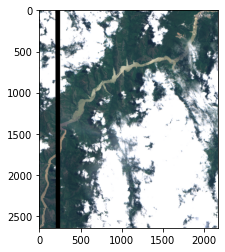

In [11]:
import matplotlib.pyplot as plt

plt.imshow(rgb_2_show[0])

In [14]:
from src.models.model_setup import get_model_inference_function
inference_function = get_model_inference_function(model, config,apply_normalization=False)

100%|██████████| 11/11 [02:21<00:00, 12.85s/it]


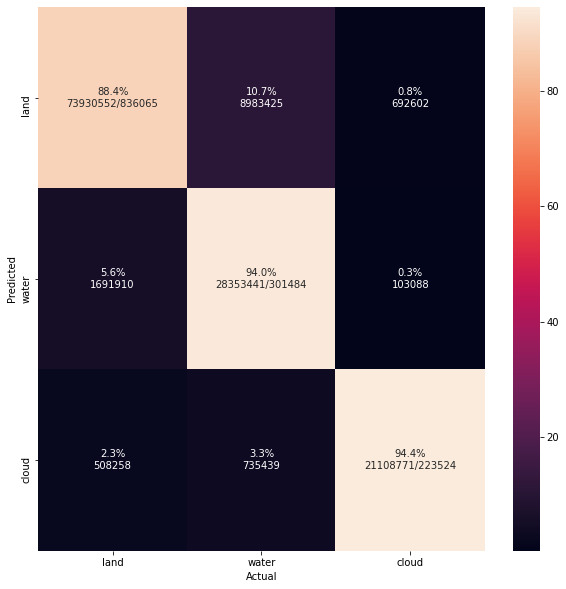

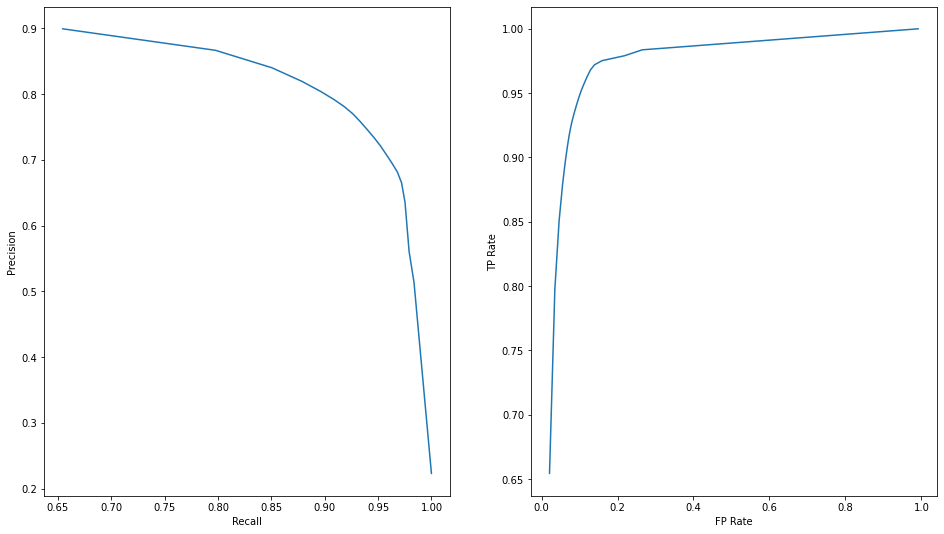

Per Class IOU {
    "cloud": 0.9118985190959903,
    "land": 0.8615936926265251,
    "water": 0.7111953622746942
}


In [15]:
import torch
import numpy as np
import pandas as pd
from src.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    config.model_params.hyperparameters.num_classes, 
    label_names=config.model_params.hyperparameters.label_names, 
    thresholds_water=np.arange(0, 1, .05), 
    plot=False)
metrics.plot_metrics(mets, config.model_params.hyperparameters.label_names)

In [ ]:
# mets = metrics.compute_metrics(dl, inference_func2, opt2.num_class, label_names, thresholds_water=np.arange(0, 1, .05), plot=True)
# metrics.plot_metrics(mets, label_names)